# 수원시 GTX 노선 설립에 따른 감성 분석 및 주택 가격 요인 분석

## 감성 분석

### -네이버 뉴스 크롤링

 ##### 데이터 전처리 순서
 
 1. 토큰화(Tokenization)
 - 문자열에서 단어로 분리시키는 단계
 
 2. 불용어 제거(Stop word elimination)
 - 전치사, 관사 등 너무 많이 등장하는 단어 등 문장이나 문서의 특징을 표현하는데 불필요한 단어를 삭제하는 단계
 
 3. 어간 추출(stemming)
 - 단어의 기본 형태를 추출하는 단계
 
 4. 문서 표현 (Representation)
 - 주어진 문서나 문장을 하나의 벡터로 표현하는 단계
 - 단어들을 모두 인덱싱하고 주어진 문서에 존재하는 단어의 빈도수를 사용하여 문서를 표현 


In [1]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install beautifulsoup4 

In [3]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
from selenium import webdriver
driver = webdriver.Chrome('chromedriver')

In [3]:
import urllib
import urllib.request
from urllib.request import urlopen
from selenium import webdriver
from bs4 import BeautifulSoup 

def getFirstChild(parent, tagName):
#    print(parent)
    for child in parent.children:
        if(child.name == tagName):
#            print(child)
            return child
        
    return None

def getSearchResult(url):
    
    try:
        driver.get(url)
        response = driver.page_source
    except:
        print("driver.get Error! : " + url)
        return False, None, None, None

    soup = BeautifulSoup(response, "html.parser")

    search_count = 0

    title_desc_all_my = soup.find('div', class_="title_desc all_my") # <div class="title_desc all_my"><span>1-10 / 682,261건</span></div>
    if title_desc_all_my == None:
        print("No <div class=title_desc all_my>")
        return False, None, None, None
        
    search_count_text = title_desc_all_my.find('span').get_text() #1-10 / 682,261건
    if search_count_text == None:
        print("No <span class=search_count_text>")
        return False, None, None, None
        
    search_count_text = search_count_text.replace(",","")
    sep_pos = search_count_text.find("-")
    if sep_pos < 0:
        return False, None, None, None

    start_idx = int(search_count_text[:sep_pos])
        
    sep_pos = search_count_text.find("/")
    if sep_pos < 0:
        return False, None, None, None

    search_total_count = int(search_count_text[sep_pos+1:len(search_count_text)-1])

    return True, start_idx, search_total_count, soup



In [4]:
#2017년 7월부터 네이버뉴스 크롤링// 매매+수원+gtx 로 단어 검색
import sys
import datetime
from tqdm import tqdm

SEARCH_WORD = "매매+수원+gtx"
BASE_URL = "https://search.naver.com/search.naver?&where=news&pd=3&query="
DAYS_SEARCH = 30

news_link = []

req_start = 1
err_count = 0
total_result_count = 0

start_dt = datetime.datetime.strptime('2017.07.01', '%Y.%m.%d')
last_dt = datetime.datetime.now()-datetime.timedelta(days=30)

ds = start_dt.strftime('%Y.%m.%d')
de = last_dt.strftime('%Y.%m.%d')

url = BASE_URL + urllib.parse.quote(SEARCH_WORD) + "&start=1&ds="+ds + "&de="+de
result = getSearchResult(url)
if not result[0]:
    print("Error getting url : " + url)
    sys.exit()

search_total_count = result[2]
print("search_total_count="+str(search_total_count))
pbar = tqdm(total=search_total_count)

while True:

    ds = start_dt.strftime('%Y.%m.%d')
    end_dt = min(start_dt + datetime.timedelta(days=DAYS_SEARCH), last_dt)
    de = end_dt.strftime('%Y.%m.%d')

    url = BASE_URL + urllib.parse.quote(SEARCH_WORD) + "&start=" + str(req_start) + "&ds="+ds + "&de="+de
#    print(url)

    result = getSearchResult(url)
    if not result[0]:
        err_count = err_count + 1
        continue
        
    if(err_count >= 3): # 3회 이상 오류나면 빠져나간다
        break

    start_idx = result[1]
    if start_idx < req_start:
        if end_dt < last_dt:
            start_dt = end_dt + datetime.timedelta(days=30)
            end_dt = start_dt + datetime.timedelta(days=DAYS_SEARCH)
            req_start = 1
            continue
        else:
            break
        
    soup = result[3]

    news_lists = []

    page_item_count = 0
    for child in soup.find('ul', class_="type01").children:
        if(child.name == "li"):
            news_lists.append(child)
            page_item_count = page_item_count + 1

    req_start = req_start + page_item_count

    for news in news_lists:
        news_target = getFirstChild(news, "dl") # 바로 밑의 <dl> <dt><a>...</a></dt> <dd><span>디지털타임스</span>5일 전<a>네이버뉴스</a></dd> </dl>
        news_target = getFirstChild(news_target, "dd") # 바로 밑의 <dd>
        news_target = getFirstChild(news_target, "a") # 바로 밑의 <a> => Naver뉴스 인 경우만 있다
        if news_target != None:
            if "naver" in news_target.attrs['href']:
                news_item_link = news_target.attrs['href']
                news_link.append(news_item_link)
    
    if pbar is not None:
#        print("pbar update")
        pbar.update(page_item_count)


if pbar is not None:
    pbar.close()
    
print(len(news_link)) 


  0%|                                                                                         | 0/1941 [00:00<?, ?it/s]

search_total_count=1941


 59%|█████████████████████████████████████████████▋                                | 1136/1941 [03:03<02:10,  6.19it/s]

427


In [5]:
import ast
naver_news_title = []
naver_news_content = []
date_text = []


for n in tqdm(range(len(news_link))):
    
    ########### 긁어온 URL로 접속하기 ############    
    try:
        driver.get(news_link[n])
#        print(news_link[n])

    except:
        print("Error! getting url="+news_link[n])
        continue


    try:
        response = driver.page_source

    except UnexpectedAlertPresentException:
        driver.switch_to_alert().accept()
        print("게시글이 삭제된 경우입니다.")
        continue

    soup = BeautifulSoup(response, "html.parser")

    ### 날짜 긁어오기 #####
    date = None
    
    try:
        item = soup.find('div', class_="sponsor")
        date = item.find('span', class_='t11').get_text()
        
    except:
        date = "OUTLINK"
        
    date_text.append(date)
    
    
    
    ###### 뉴스 타이틀 긁어오기 ######

    title = None

    try:
        item = soup.find('div', class_="article_info")
        title = item.find('h3', class_="tts_head").get_text()
        #print(title)

    except:
        title = "OUTLINK"

    #print(title)
    naver_news_title.append(title)

    ###### 뉴스 본문 긁어오기 ######

    doc = None
    text = ""

    data = soup.find_all("div", {"class" : "_article_body_contents"})
    if data:
        for item in data:

            text = text + str(item.find_all(text=True)).strip()
            text = ast.literal_eval(text)
            doc = ' '.join(text)

    else:
        doc = "OUTLINK"
    naver_news_content.append(doc.replace('\n', ' '))
    

                
print("Completed!!!")

100%|████████████████████████████████████████████████████████████████████████████████| 427/427 [05:39<00:00,  1.26it/s]

Completed!!!


In [6]:
len(naver_news_title)

427

In [7]:
import pandas as pd

date = pd.DataFrame(date_text)
title = pd.DataFrame(naver_news_title)
content = pd.DataFrame(naver_news_content)
# date = date.T
# title = title.T
# content = content.T



# # make .csv file
naver_news_df = pd.concat([date,title,content],axis=1)
naver_news_df.columns = ['date','title','content']
naver_news_df.head(10)

,date,title,content
0,2017.07.21. 오전 10:54,GTX 2025년까지 모든노선 완공… 수혜지 '들썩',본문 내용 TV플레이어 // TV플레이어 // flash...
1,2017.07.17. 오후 2:12,"“전세난 NO”, 서울 출퇴근 편한 아파트 인기",본문 내용 TV플레이어 // TV플레이어 // flash...
2,2017.07.12. 오전 3:04,‘급행열차 수혜’ 수도권 8곳 뜬다… 연내 3만채 분양,본문 내용 TV플레이어 // TV플레이어 // flash...
3,2017.07.06. 오전 5:01,6·19 부동산 규제에도 끄떡 않는 광명시…왜?,본문 내용 TV플레이어 // TV플레이어 // flash...
4,2017.07.06. 오전 5:01,6·19 부동산 규제에도 끄떡 않는 광명시…왜?,본문 내용 TV플레이어 // TV플레이어 // flash...
5,2017.07.07. 오후 3:26,서울 출퇴근 편리한 힐스테이트 평택에 수요자 관심 ‘집중’,본문 내용 TV플레이어 // TV플레이어 // flash...
6,2017.07.05. 오후 3:29,"“전세난 NO”, 서울 출퇴근 편한 경기권 새아파트 ‘눈길’",본문 내용 TV플레이어 // TV플레이어 // flash...
7,2017.07.05. 오후 3:45,'전세난 탈출구'.. 서울 출퇴근 편한 경기권 새아파트 '인기',본문 내용 TV플레이어 // TV플레이어 // flash...
8,2017.07.07. 오후 2:42,교통 입지 좋은 인천 남동구 `단풍마을휴먼시아` 문의 활발,본문 내용 TV플레이어 // TV플레이어 // flash...
9,2017.07.06. 오후 3:23,"“전세난 피하자”, 서울 출퇴근 편리한 경기권 새아파트 어디?",본문 내용 TV플레이어 // TV플레이어 // flash...


In [8]:
naver_news_df.shape

(427, 3)

In [135]:
#엑셀로 뽑아내기
#naver_news_df.to_csv("naver_news.csv", index=True, encoding='euc-kr' )

In [9]:
#date(년월일만 뽑기)
naver_news_df['date'] = naver_news_df.date.str.split('. ').str[0]

In [10]:
naver_news_df

,date,title,content
0,2017.07.21,GTX 2025년까지 모든노선 완공… 수혜지 '들썩',본문 내용 TV플레이어 // TV플레이어 // flash...
1,2017.07.17,"“전세난 NO”, 서울 출퇴근 편한 아파트 인기",본문 내용 TV플레이어 // TV플레이어 // flash...
2,2017.07.12,‘급행열차 수혜’ 수도권 8곳 뜬다… 연내 3만채 분양,본문 내용 TV플레이어 // TV플레이어 // flash...
3,2017.07.06,6·19 부동산 규제에도 끄떡 않는 광명시…왜?,본문 내용 TV플레이어 // TV플레이어 // flash...
4,2017.07.06,6·19 부동산 규제에도 끄떡 않는 광명시…왜?,본문 내용 TV플레이어 // TV플레이어 // flash...
...,...,...,...
422,2020.08.06,[우리동네 지역전문가] ‘수인선’에 ‘신안산선’ 호재를 더한 ‘단원구 초지동’… 교...,본문 내용 TV플레이어 // TV플레이어 // flash...
423,2020.08.04,"‘웃돈 예감’, 트리플 역세권 ‘의정부역스카이자이’ 관심",본문 내용 TV플레이어 // TV플레이어 // flash...
424,2020.08.03,‘의정부·양주’ 조정대상지역인데 후끈?,본문 내용 TV플레이어 // TV플레이어 // flash...
425,2020.08.03,‘의정부·양주’ 조정대상지역인데 후끈?,본문 내용 TV플레이어 // TV플레이어 // flash...


In [11]:
# content ---> function _flash_removeCallback() {} 앞에 문자열 모두 지우기
naver_news_df['content'] = naver_news_df.content.str.split("{}").str[1] 

In [12]:
naver_news_df

,date,title,content
0,2017.07.21,GTX 2025년까지 모든노선 완공… 수혜지 '들썩',[한국경제TV 신동호 기자] 국토교통부가 예비타당성 조사가 완료된 수도권 광...
1,2017.07.17,"“전세난 NO”, 서울 출퇴근 편한 아파트 인기",서울 전셋값이 꾸준히 상승하는 가운데 서울로의 접근성이 좋은 경기도 새 아파...
2,2017.07.12,‘급행열차 수혜’ 수도권 8곳 뜬다… 연내 3만채 분양,\t \t[동아일보] 광역철도 확충따라 주변 부동산 들썩 서울과 수도권 외곽을...
3,2017.07.06,6·19 부동산 규제에도 끄떡 않는 광명시…왜?,- 대책 발표 후에도 집값 1000만원↑ - 아파트값 상승률 3개월째 올라 ...
4,2017.07.06,6·19 부동산 규제에도 끄떡 않는 광명시…왜?,- 대책 발표 후에도 집값 1000만원↑ - 아파트값 상승률 3개월째 올라 ...
...,...,...,...
422,2020.08.06,[우리동네 지역전문가] ‘수인선’에 ‘신안산선’ 호재를 더한 ‘단원구 초지동’… 교...,"\t \t오는 9월 12일, ‘수원-인천 복선전철(수인선)’ 3단계 수원~한대..."
423,2020.08.04,"‘웃돈 예감’, 트리플 역세권 ‘의정부역스카이자이’ 관심",역세권 단지 여부는 내 집 마련 전 고려 1순위다. 그러나 이제는 단순 역세...
424,2020.08.03,‘의정부·양주’ 조정대상지역인데 후끈?,GTX· 7호선 등 대형 교통개발 호재가 가득한 경기 ‘의정부·양주’의 하반...
425,2020.08.03,‘의정부·양주’ 조정대상지역인데 후끈?,GTX· 7호선 등 대형 교통개발 호재가 가득한 경기 ‘의정부·양주’의 하반...


In [13]:
#중복값 확인
naver_news_df['title'].nunique(),naver_news_df['content'].nunique()

(371, 375)

In [14]:
naver_news = naver_news_df.drop_duplicates(['content'], keep='first')
naver_news.shape

(375, 3)

# 형태소 분석

In [15]:
import scipy as sp
import pandas as pd
import numpy as np

from konlpy.tag import Kkma
from konlpy.tag import Hannanum
from konlpy.tag import Okt
from konlpy.tag import *
import nltk
import pickle

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline
import os
import matplotlib as plt
import seaborn as sns
import graphviz
from sklearn.tree import export_graphviz

import matplotlib.font_manager as fm
plt.rc('font',family='NanumGothic')

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [16]:
title_list = naver_news.title.values.tolist()
content_list = naver_news.content

In [17]:
print(len(title_list))
title_list

375


["GTX 2025년까지 모든노선 완공… 수혜지 '들썩'",
 ' “전세난 NO”, 서울 출퇴근 편한 아파트 인기',
 '‘급행열차 수혜’ 수도권 8곳 뜬다… 연내 3만채 분양',
 '6·19 부동산 규제에도 끄떡 않는 광명시…왜?',
 '서울 출퇴근 편리한 힐스테이트 평택에 수요자 관심 ‘집중’',
 '“전세난 NO”, 서울 출퇴근 편한 경기권 새아파트 ‘눈길’',
 "'전세난 탈출구'.. 서울 출퇴근 편한 경기권 새아파트 '인기'",
 '교통 입지 좋은 인천 남동구 `단풍마을휴먼시아` 문의 활발',
 '“전세난 피하자”, 서울 출퇴근 편리한 경기권 새아파트 어디?',
 '6.19대책 이후 풍선효과 `동탄2 동원로얄듀크 비스타 오피스텔` 관심↑',
 '교통호재 풍부한 인천 남구 `주안더월드스테이트` 최근 매매가가…',
 "[입주단지를 찾아서] 화성시 가산동 SK건설 '신동탄 SK뷰파크 2차' 삼성전자 등 배후수요 탄탄",
 '스타필드고양·이케아 가까운 몰세권 ‘원흥도래울마을LH2단지’ ',
 "구파발 초역세권 '은평 솔하임' 상가, 개발 호재에 눈길",
 '[MK 분양뉴스] 구파발역 초역세권 ‘은평 솔하임 단지 내 상가’ 임대·매매',
 "대학교 기숙사 부족 '월세족' 학교 인근 아파텔로 발길",
 "3호선 구파발 역세권 '은평 솔하임 상업시설' 활성화 기대",
 '롯데몰 은평 맞은편 ‘은평 솔하임 단지 내 상가’ 임차인 모집',
 "하룻새 웃돈 2배 '껑충'…'구름탄' 운정  ",
 '대학교 인근 소형 아파텔 잡아 임대투자 해볼까?',
 '"신분당선·SRT·강릉행KTX 등 서울 잇는 新철도라인 내 분양예정지는 어디?"',
 '부진한 동탄2…옆동네 광교처럼 반등할까',
 '경기도 남,북부 부동산 시장 온도차 심해',
 "[경기 남부발 '입주쇼크']쏟아지는 물량에 전세시장 '소화불량'",
 "[시장보고서] 스타필드고양·이케아 가까운 몰세권 ‘원흥도래울마을LH2,4,6단지'",
 " 규제 피한 유동자금 몰리는 상가…'별내역 아이플레이스' 주목",
 '경기도 남·

### list 화 하여 \n 으로 구분

In [18]:
title_text = ''

for each_line in title_list:
    title_text = title_text + each_line + '\n'
    
title_text

'GTX 2025년까지 모든노선 완공… 수혜지 \'들썩\'\n “전세난 NO”, 서울 출퇴근 편한 아파트 인기\n‘급행열차 수혜’ 수도권 8곳 뜬다… 연내 3만채 분양\n6·19 부동산 규제에도 끄떡 않는 광명시…왜?\n서울 출퇴근 편리한 힐스테이트 평택에 수요자 관심 ‘집중’\n“전세난 NO”, 서울 출퇴근 편한 경기권 새아파트 ‘눈길’\n\'전세난 탈출구\'.. 서울 출퇴근 편한 경기권 새아파트 \'인기\'\n교통 입지 좋은 인천 남동구 `단풍마을휴먼시아` 문의 활발\n“전세난 피하자”, 서울 출퇴근 편리한 경기권 새아파트 어디?\n6.19대책 이후 풍선효과 `동탄2 동원로얄듀크 비스타 오피스텔` 관심↑\n교통호재 풍부한 인천 남구 `주안더월드스테이트` 최근 매매가가…\n[입주단지를 찾아서] 화성시 가산동 SK건설 \'신동탄 SK뷰파크 2차\' 삼성전자 등 배후수요 탄탄\n스타필드고양·이케아 가까운 몰세권 ‘원흥도래울마을LH2단지’ \n구파발 초역세권 \'은평 솔하임\' 상가, 개발 호재에 눈길\n[MK 분양뉴스] 구파발역 초역세권 ‘은평 솔하임 단지 내 상가’ 임대·매매\n대학교 기숙사 부족 \'월세족\' 학교 인근 아파텔로 발길\n3호선 구파발 역세권 \'은평 솔하임 상업시설\' 활성화 기대\n롯데몰 은평 맞은편 ‘은평 솔하임 단지 내 상가’ 임차인 모집\n하룻새 웃돈 2배 \'껑충\'…\'구름탄\' 운정  \n대학교 인근 소형 아파텔 잡아 임대투자 해볼까?\n"신분당선·SRT·강릉행KTX 등 서울 잇는 新철도라인 내 분양예정지는 어디?"\n부진한 동탄2…옆동네 광교처럼 반등할까\n경기도 남,북부 부동산 시장 온도차 심해\n[경기 남부발 \'입주쇼크\']쏟아지는 물량에 전세시장 \'소화불량\'\n[시장보고서] 스타필드고양·이케아 가까운 몰세권 ‘원흥도래울마을LH2,4,6단지\'\n 규제 피한 유동자금 몰리는 상가…\'별내역 아이플레이스\' 주목\n경기도 남·북부 부동산 시장 온도차 심해\n9호선 연장 수혜 기대되는 ‘고덕역 효성해링턴 타워 더퍼스트’ 분

In [19]:
from konlpy.tag import Twitter; t=Twitter()
tokens_ko = t.morphs(title_text)

In [20]:
tokens_ko

['GTX',
 '2025년',
 '까지',
 '모든',
 '노선',
 '완공',
 '…',
 '수혜',
 '지',
 "'",
 '들썩',
 "'",
 '\n ',
 '“',
 '전세',
 '난',
 'NO',
 '”',
 ',',
 '서울',
 '출퇴근',
 '편한',
 '아파트',
 '인기',
 '\n',
 '‘',
 '급행열차',
 '수혜',
 '’',
 '수도권',
 '8',
 '곳',
 '뜬다',
 '…',
 '연내',
 '3만',
 '채',
 '분양',
 '\n',
 '6',
 '·',
 '19',
 '부동산',
 '규제',
 '에도',
 '끄',
 '떡',
 '않는',
 '광명시',
 '…',
 '왜',
 '?',
 '\n',
 '서울',
 '출퇴근',
 '편리한',
 '힐스테이트',
 '평택',
 '에',
 '수요',
 '자',
 '관심',
 '‘',
 '집중',
 '’',
 '\n',
 '“',
 '전세',
 '난',
 'NO',
 '”',
 ',',
 '서울',
 '출퇴근',
 '편한',
 '경기',
 '권',
 '새',
 '아파트',
 '‘',
 '눈길',
 '’',
 '\n',
 "'",
 '전세',
 '난',
 '탈출',
 '구',
 "'..",
 '서울',
 '출퇴근',
 '편한',
 '경기',
 '권',
 '새',
 '아파트',
 "'",
 '인기',
 "'",
 '\n',
 '교통',
 '입지',
 '좋은',
 '인천',
 '남동구',
 '`',
 '단풍',
 '마을',
 '휴먼시아',
 '`',
 '문의',
 '활발',
 '\n',
 '“',
 '전세',
 '난',
 '피하',
 '자',
 '”',
 ',',
 '서울',
 '출퇴근',
 '편리한',
 '경기',
 '권',
 '새',
 '아파트',
 '어디',
 '?',
 '\n',
 '6.19',
 '대책',
 '이후',
 '풍선',
 '효과',
 '`',
 '동탄',
 '2',
 '동원',
 '로얄',
 '듀크',
 '비스타',
 '오피스텔',
 '`',
 '관심',
 '↑',

In [21]:
import nltk
ko = nltk.Text(tokens_ko)
ko

<Text: GTX 2025년 까지 모든 노선 완공 … 수혜...>

In [22]:
print(len(ko.tokens)) ##토큰 전체 갯수
print(len(set(ko.tokens)))  ## 토큰 unique 개수

5909
1487


In [23]:
# 빈도수가 높은 단어 출력
ko.vocab().most_common(200)

[('\n', 367),
 ("'", 171),
 ('·', 143),
 ('…', 120),
 ('‘', 117),
 ('’', 101),
 (',', 89),
 ('아파트', 84),
 ('서울', 70),
 ('"', 62),
 ('집값', 59),
 ('에', 53),
 ('[', 47),
 ('규제', 46),
 ('지역', 46),
 ('분양', 45),
 ('효과', 45),
 ('수원', 45),
 ('풍선', 44),
 (']', 43),
 ('수도권', 38),
 ('인천', 38),
 ('권', 37),
 ('부동산', 36),
 ('`', 36),
 ('2', 34),
 ('주', 34),
 ('?', 32),
 ('은', 31),
 ('값', 30),
 ('대책', 28),
 ('상승', 28),
 ('호재', 27),
 ('GTX', 25),
 ('매매', 25),
 ('신도시', 25),
 ('하락', 24),
 ('교통', 23),
 ('경기', 22),
 ('주목', 22),
 ('가', 21),
 ('역세', 20),
 ('로', 20),
 ('시장', 20),
 ('강남', 20),
 ('단지', 19),
 ('3', 19),
 ('용인', 19),
 ('“', 18),
 ('”', 18),
 ('더', 18),
 ('이', 18),
 ('동탄', 17),
 ('-', 17),
 ('까지', 16),
 ('세', 16),
 ('도', 16),
 ('조정', 16),
 ('오피스텔', 15),
 ('기', 15),
 ('전세', 14),
 ('한', 14),
 ('서', 14),
 ('의', 14),
 ('전', 14),
 ('거래', 13),
 ("'…", 13),
 ('연속', 13),
 ('폭', 13),
 ('수혜', 12),
 ('이후', 12),
 ('투자', 12),
 ('’…', 12),
 ('청약', 12),
 ('20', 12),
 ('지', 11),
 ('인기', 11),
 ('눈길', 11),
 ('↑', 

# 불용어 제거하기

In [158]:
#숫자와 영문 제거
import re

def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') 
    result = hangul.sub('', text)
    return result

naver_news['ko_text_title'] = naver_news['title'].apply(lambda x : text_cleaning(x))
naver_news.head()

,date,title,content,ko_text_title,nouns
0,2017.07.21,GTX 2025년까지 모든노선 완공… 수혜지 '들썩',[한국경제TV 신동호 기자] 국토교통부가 예비타당성 조사가 완료된 수도권 광...,년까지 모든노선 완공 수혜지 들썩,"[0, 0, 2]"
1,2017.07.17,"“전세난 NO”, 서울 출퇴근 편한 아파트 인기",서울 전셋값이 꾸준히 상승하는 가운데 서울로의 접근성이 좋은 경기도 새 아파...,전세난 서울 출퇴근 편한 아파트 인기,"[0, 0, 0, 0, 2]"
2,2017.07.12,‘급행열차 수혜’ 수도권 8곳 뜬다… 연내 3만채 분양,\t \t[동아일보] 광역철도 확충따라 주변 부동산 들썩 서울과 수도권 외곽을...,급행열차 수혜 수도권 곳 뜬다 연내 만채 분양,"[1, 2, 0, 0, 0]"
3,2017.07.06,6·19 부동산 규제에도 끄떡 않는 광명시…왜?,- 대책 발표 후에도 집값 1000만원↑ - 아파트값 상승률 3개월째 올라 ...,부동산 규제에도 끄떡 않는 광명시왜,"[0, -1, 0]"
5,2017.07.07,서울 출퇴근 편리한 힐스테이트 평택에 수요자 관심 ‘집중’,[스포츠서울 김수지기자]서울 전셋값이 꾸준히 상승하는 가운데 서울 접근성이 ...,서울 출퇴근 편리한 힐스테이트 평택에 수요자 관심 집중,"[0, 0, 0, 0, 0, 1, 0]"


In [159]:
#한글어 불용어 사전과 새로운_불용어사전을 만들어 불용어 제거
from konlpy.tag import Okt
from collections import Counter

korean_stopwords_path = './korean_stopwords.txt'

with open(korean_stopwords_path, encoding="utf8") as f:
    stopwords = f.readlines()

stopwords= [x.strip() for x in stopwords]
news_stopwords = ['\n',"'",'…',',','[',']','(',')','"','외지']
for stopword in news_stopwords:
    stopwords.append(stopword)

In [160]:
def get_nouns(x):
    nouns_tagger = Okt()
    nouns = nouns_tagger.nouns(x)
    # 한글자 키워드를 제거합니다.
    nouns = [noun for noun in nouns if len(noun) > 1]
    # 불용어를 제거합니다.
    nouns = [noun for noun in nouns if noun not in stopwords]
    return nouns

# ‘ko_text’ 피처에 이를 적용합니다.
naver_news['nouns'] = naver_news['ko_text_title'].apply(lambda x: get_nouns(x))
print(naver_news.shape)
naver_news.head(30)

(375, 5)


,date,title,content,ko_text_title,nouns
0,2017.07.21,GTX 2025년까지 모든노선 완공… 수혜지 '들썩',[한국경제TV 신동호 기자] 국토교통부가 예비타당성 조사가 완료된 수도권 광...,년까지 모든노선 완공 수혜지 들썩,"[노선, 완공, 수혜]"
1,2017.07.17,"“전세난 NO”, 서울 출퇴근 편한 아파트 인기",서울 전셋값이 꾸준히 상승하는 가운데 서울로의 접근성이 좋은 경기도 새 아파...,전세난 서울 출퇴근 편한 아파트 인기,"[전세, 서울, 출퇴근, 아파트, 인기]"
2,2017.07.12,‘급행열차 수혜’ 수도권 8곳 뜬다… 연내 3만채 분양,\t \t[동아일보] 광역철도 확충따라 주변 부동산 들썩 서울과 수도권 외곽을...,급행열차 수혜 수도권 곳 뜬다 연내 만채 분양,"[급행열차, 수혜, 수도권, 연내, 분양]"
3,2017.07.06,6·19 부동산 규제에도 끄떡 않는 광명시…왜?,- 대책 발표 후에도 집값 1000만원↑ - 아파트값 상승률 3개월째 올라 ...,부동산 규제에도 끄떡 않는 광명시왜,"[부동산, 규제, 광명시]"
5,2017.07.07,서울 출퇴근 편리한 힐스테이트 평택에 수요자 관심 ‘집중’,[스포츠서울 김수지기자]서울 전셋값이 꾸준히 상승하는 가운데 서울 접근성이 ...,서울 출퇴근 편리한 힐스테이트 평택에 수요자 관심 집중,"[서울, 출퇴근, 힐스테이트, 평택, 수요, 관심, 집중]"
6,2017.07.05,"“전세난 NO”, 서울 출퇴근 편한 경기권 새아파트 ‘눈길’",\t \t[서울경제] 서울 전셋값이 꾸준히 상승하는 가운데 서울로의 접근성이 ...,전세난 서울 출퇴근 편한 경기권 새아파트 눈길,"[전세, 서울, 출퇴근, 경기, 아파트, 눈길]"
7,2017.07.05,'전세난 탈출구'.. 서울 출퇴근 편한 경기권 새아파트 '인기',"-서울 아파트 전세값, 경기도 평균 매매값보다 30% 가량 높아 -평택, ...",전세난 탈출구 서울 출퇴근 편한 경기권 새아파트 인기,"[전세, 탈출, 서울, 출퇴근, 경기, 아파트, 인기]"
8,2017.07.07,교통 입지 좋은 인천 남동구 `단풍마을휴먼시아` 문의 활발,\t \t최근 인천에는 연이은 교통 호재가 들려오고 있다. 인천발 KTX 가...,교통 입지 좋은 인천 남동구 단풍마을휴먼시아 문의 활발,"[교통, 입지, 인천, 남동구, 단풍, 마을, 휴먼시아, 문의, 활발]"
9,2017.07.06,"“전세난 피하자”, 서울 출퇴근 편리한 경기권 새아파트 어디?",\t \t서울 전셋값이 꾸준히 상승하는 가운데 서울로의 접근성이 좋은 경기도 ...,전세난 피하자 서울 출퇴근 편리한 경기권 새아파트 어디,"[전세, 피하, 서울, 출퇴근, 경기, 아파트]"
10,2017.07.11,6.19대책 이후 풍선효과 `동탄2 동원로얄듀크 비스타 오피스텔` 관심↑,6.19 부동산 대책으로 수도권 오피스텔 시장이 더욱 핫( Hot )해지고 ...,대책 이후 풍선효과 동탄 동원로얄듀크 비스타 오피스텔 관심,"[대책, 이후, 풍선, 효과, 동탄, 동원, 로얄, 듀크, 비스타, 오피스텔, 관심]"


In [161]:
# naver_news.to_csv("naver_news_2.csv", index=True, encoding='euc-kr' )

#  Apriori 알고리즘을 이용한 연관 분석 

In [27]:
pip install apriori apyori

Note: you may need to restart the kernel to use updated packages.


In [162]:
# 트랜잭션 데이터를 추출합니다.
transactions = naver_news['nouns'].tolist()
transactions = [transaction for transaction in transactions if transaction] # 공백 문자열을 방지합니다.
print(transactions)

[['노선', '완공', '수혜'], ['전세', '서울', '출퇴근', '아파트', '인기'], ['급행열차', '수혜', '수도권', '연내', '분양'], ['부동산', '규제', '광명시'], ['서울', '출퇴근', '힐스테이트', '평택', '수요', '관심', '집중'], ['전세', '서울', '출퇴근', '경기', '아파트', '눈길'], ['전세', '탈출', '서울', '출퇴근', '경기', '아파트', '인기'], ['교통', '입지', '인천', '남동구', '단풍', '마을', '휴먼시아', '문의', '활발'], ['전세', '피하', '서울', '출퇴근', '경기', '아파트'], ['대책', '이후', '풍선', '효과', '동탄', '동원', '로얄', '듀크', '비스타', '오피스텔', '관심'], ['교통', '호재', '인천', '남구', '주안', '월드', '스테이', '최근', '매매', '가가'], ['화성시', '가산동', '건설', '동탄', '파크', '삼성', '배후', '수요', '탄탄'], ['스타', '필드', '고양', '이케아', '몰세', '원흥', '도래', '마을'], ['구파발', '은평', '솔하임', '상가', '개발', '호재', '눈길'], ['분양', '뉴스', '구파발역', '은평', '솔하임', '상가', '임대', '매매'], ['대학교', '기숙사', '부족', '월세', '학교', '인근', '아파텔', '발길'], ['호선', '구파발', '은평', '솔하임', '상업시설', '활성화', '기대'], ['롯데', '은평', '맞은편', '은평', '솔하임', '상가', '임차', '모집'], ['룻새', '웃돈', '껑충', '구름', '운정'], ['대학교', '인근', '소형', '아파텔', '임대', '투자'], ['신분당선', '강릉', '서울', '철도', '라인', '분양', '예정'], ['동탄', '동네', '광교', '반등'], ['경기도', '북부', '

In [163]:
from apyori import apriori
# 연관 분석을 수행합니다.
results = list(apriori(transactions,
    min_support=0.06,
    min_confidence=0.05,
    min_lift=1.0,
    max_length=2))
print(results)

[RelationRecord(items=frozenset({'교통'}), support=0.06149732620320856, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'교통'}), confidence=0.06149732620320856, lift=1.0)]), RelationRecord(items=frozenset({'규제'}), support=0.12032085561497326, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'규제'}), confidence=0.12032085561497326, lift=1.0)]), RelationRecord(items=frozenset({'대책'}), support=0.0748663101604278, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'대책'}), confidence=0.0748663101604278, lift=1.0)]), RelationRecord(items=frozenset({'매매'}), support=0.06417112299465241, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'매매'}), confidence=0.06417112299465241, lift=1.0)]), RelationRecord(items=frozenset({'부동산'}), support=0.09358288770053476, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'부동산'}), confidence=0.09358288770

In [164]:
# 데이터 프레임 형태로 정리합니다.
columns = ['source', 'target', 'support']
news_df = pd.DataFrame(columns=columns)

# 규칙의 조건절을 source, 결과절을 target, 지지도를 support 라는 데이터 프레임의 피처로 변환합니다.
for result in results:
    if len(result.items) == 2:
        items = [x for x in result.items]
        row = [items[0], items[1], result.support]
        series = pd.Series(row, index=news_df.columns)
        news_df = news_df.append(series, ignore_index=True)

news_df.head()

,source,target,support
0,아파트,서울,0.085561
1,효과,풍선,0.106952


In [165]:
# 말뭉치를 추출합니다.
corpus = "".join(naver_news['ko_text_title'].tolist())
print(corpus)

 년까지 모든노선 완공 수혜지 들썩 전세난  서울 출퇴근 편한 아파트 인기급행열차 수혜 수도권 곳 뜬다 연내 만채 분양 부동산 규제에도 끄떡 않는 광명시왜서울 출퇴근 편리한 힐스테이트 평택에 수요자 관심 집중전세난  서울 출퇴근 편한 경기권 새아파트 눈길전세난 탈출구 서울 출퇴근 편한 경기권 새아파트 인기교통 입지 좋은 인천 남동구 단풍마을휴먼시아 문의 활발전세난 피하자 서울 출퇴근 편리한 경기권 새아파트 어디대책 이후 풍선효과 동탄 동원로얄듀크 비스타 오피스텔 관심교통호재 풍부한 인천 남구 주안더월드스테이트 최근 매매가가입주단지를 찾아서 화성시 가산동 건설 신동탄 뷰파크 차 삼성전자 등 배후수요 탄탄스타필드고양이케아 가까운 몰세권 원흥도래울마을단지 구파발 초역세권 은평 솔하임 상가 개발 호재에 눈길 분양뉴스 구파발역 초역세권 은평 솔하임 단지 내 상가 임대매매대학교 기숙사 부족 월세족 학교 인근 아파텔로 발길호선 구파발 역세권 은평 솔하임 상업시설 활성화 기대롯데몰 은평 맞은편 은평 솔하임 단지 내 상가 임차인 모집하룻새 웃돈 배 껑충구름탄 운정  대학교 인근 소형 아파텔 잡아 임대투자 해볼까신분당선강릉행 등 서울 잇는 철도라인 내 분양예정지는 어디부진한 동탄옆동네 광교처럼 반등할까경기도 남북부 부동산 시장 온도차 심해경기 남부발 입주쇼크쏟아지는 물량에 전세시장 소화불량시장보고서 스타필드고양이케아 가까운 몰세권 원흥도래울마을단지 규제 피한 유동자금 몰리는 상가별내역 아이플레이스 주목경기도 남북부 부동산 시장 온도차 심해호선 연장 수혜 기대되는 고덕역 효성해링턴 타워 더퍼스트 분양강남까지 원스톱 강남 직통 역세권 오피스텔 인기반도건설 동탄신도시 반도유보라 아이비파크  입주 스타트연이은 호재에 수원 권선구 일대 오름세 서둔동 센트라우스 매매가는호재 가득한 판교 봇들단지휴먼시아엔파트 매매 거래돼 분양뉴스 의정부 노블리안시티 스타 소형 아파트 분양필요한 공간은 살린다  핏사이징아파트 대세높은 서울 접근성으로 주목받는 남양주 두산위브 트레지움서울 출퇴근 수월한 남양주

In [166]:
from konlpy.tag import Okt
from collections import Counter

# 명사 키워드를 추출합니다.
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(corpus)
count = Counter(nouns)

# 한글자 키워드를 제거합니다.
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})

# 키워드와 키워드 빈도 점수를 ‘node’, ‘nodesize’ 라는 데이터 프레임의 피처로 생성합니다.
node_df = pd.DataFrame(remove_char_counter.items(), columns=['node', 'nodesize'])
node_df = node_df[node_df['nodesize'] >= 10] # 시각화의 편의를 위해 ‘nodesize’ 5 이하는 제거합니다.
node_df.head(10)

,node,nodesize
2,수혜,12
3,전세,13
4,서울,68
6,아파트,84
7,인기,11
9,수도권,38
11,분양,44
12,부동산,36
13,규제,46
20,경기,21


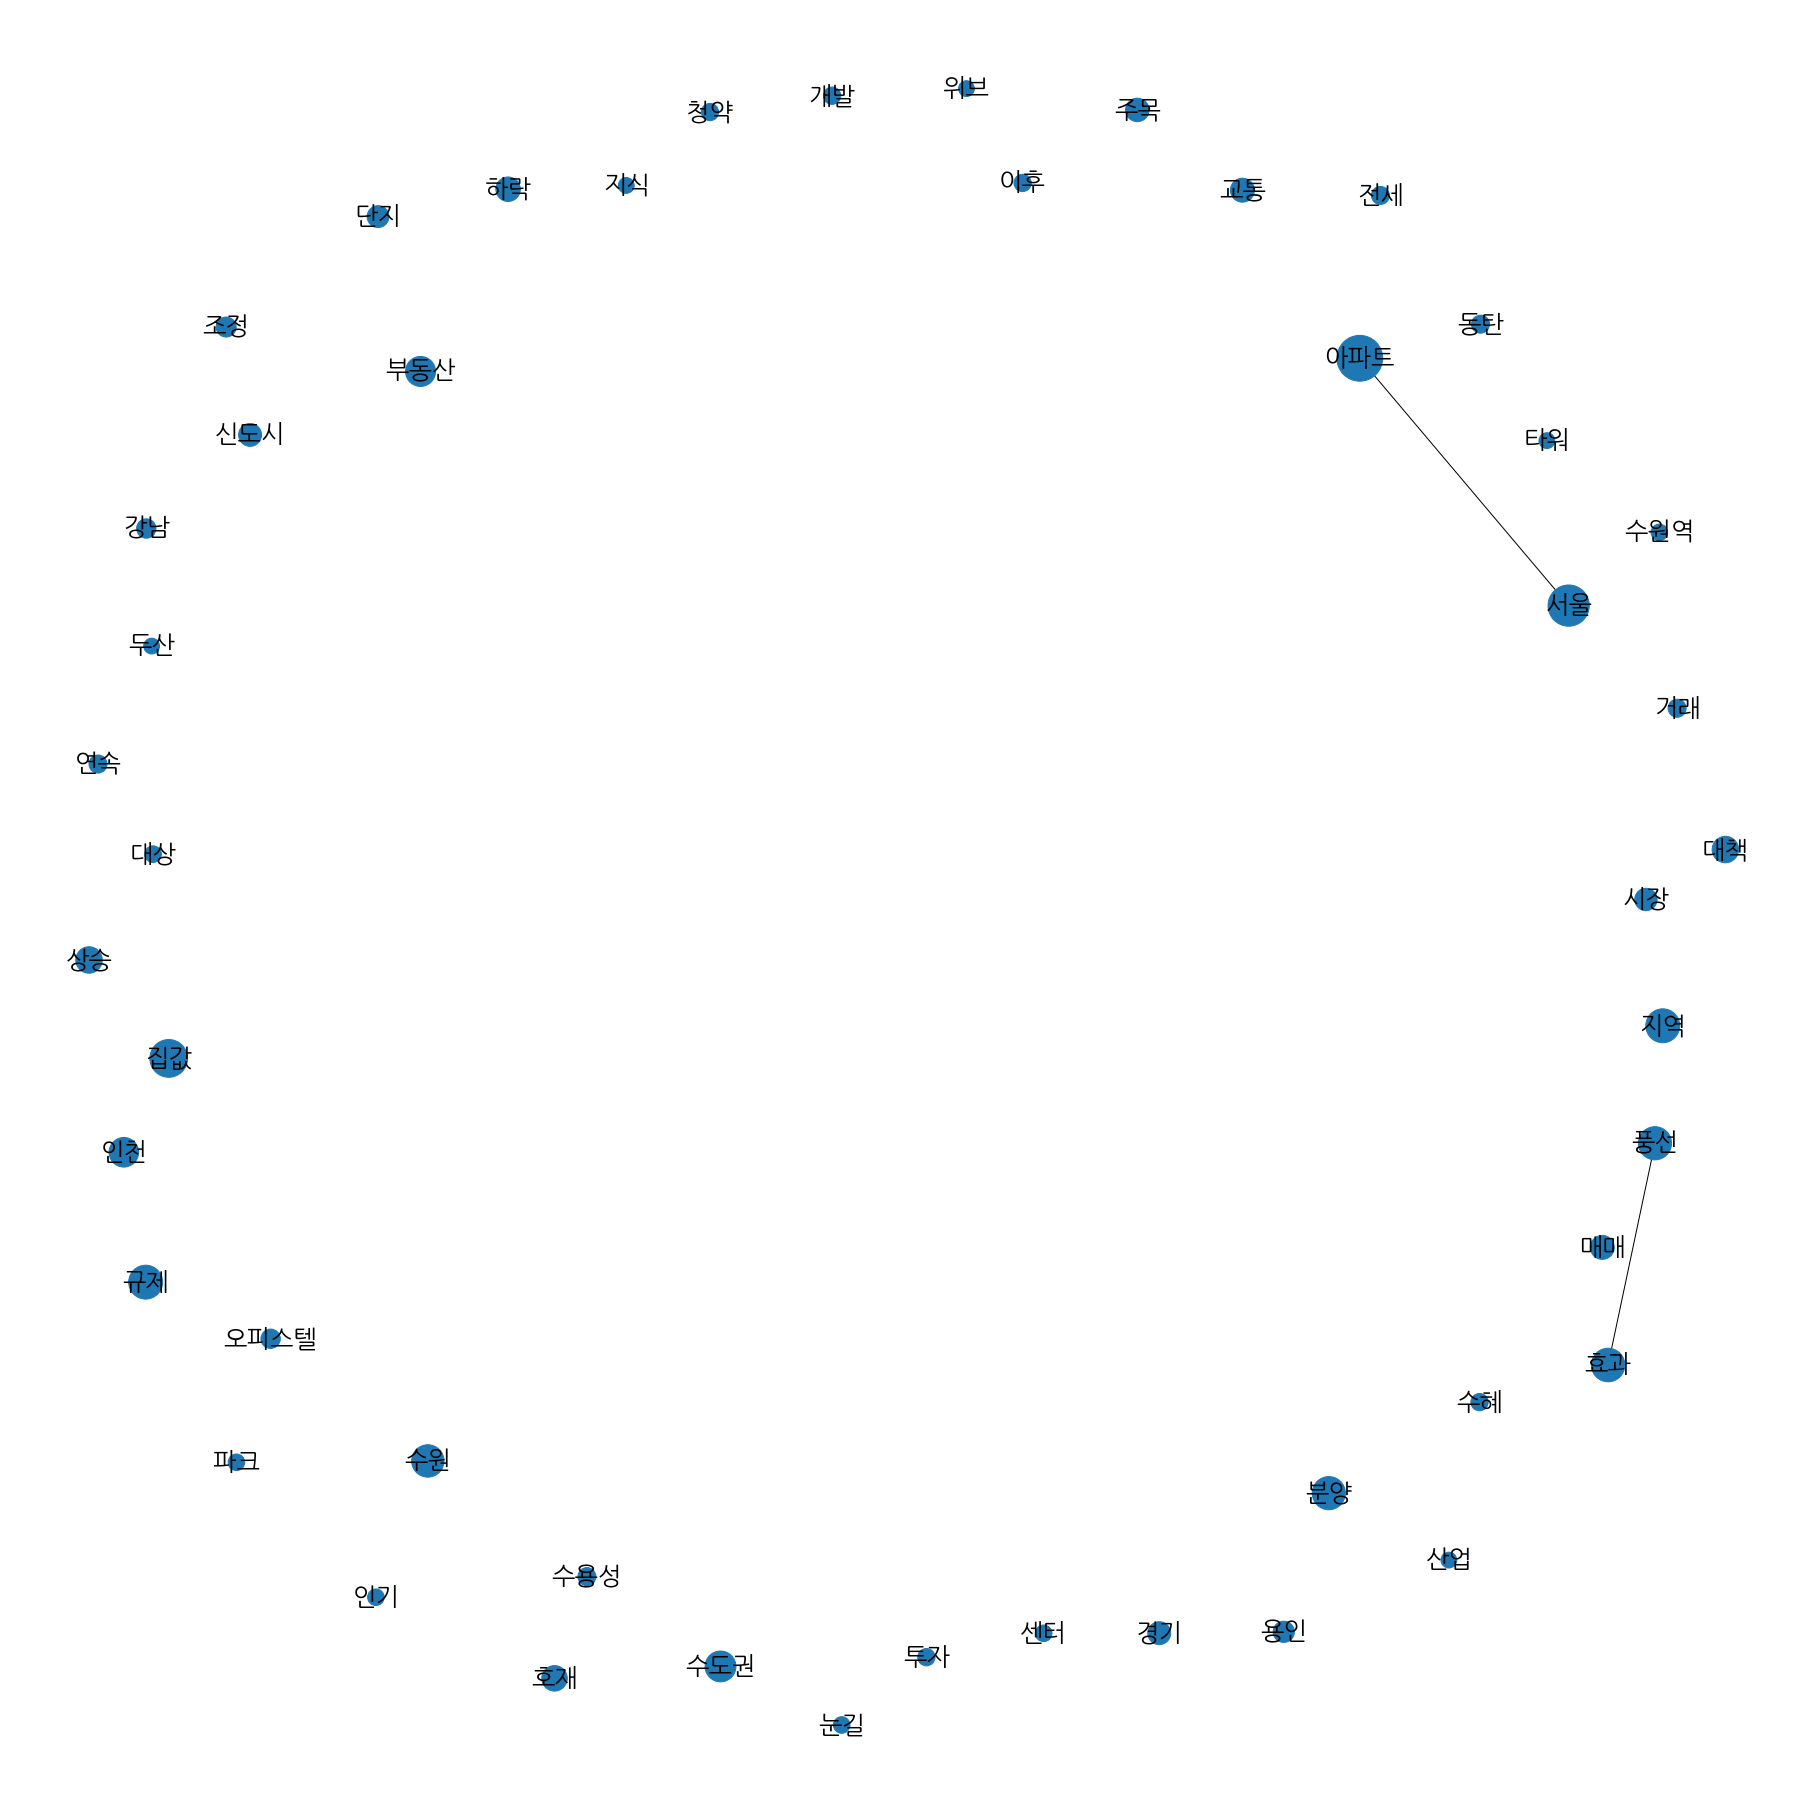

In [167]:
#단어들간의 연관성 그래프로 나타내기
import matplotlib.pyplot as plt
import networkx as nx
plt.figure(figsize=(25,25))

# networkx 그래프 객체를 생성합니다.
G = nx.Graph()

# node_df의 키워드 빈도수를 데이터로 하여, 네트워크 그래프의 ‘노드’ 역할을 하는 원을 생성합니다.
for index, row in node_df.iterrows():
    G.add_node(row['node'], nodesize=row['nodesize'])

# network_df의 연관 분석 데이터를 기반으로, 네트워크 그래프의 ‘관계’ 역할을 하는 선을 생성합니다.
for index, row in news_df.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])

# 그래프 디자인과 관련된 파라미터를 설정합니다.
pos = nx.spring_layout(G, k=0.6, iterations=50)
sizes = [G.nodes[node]['nodesize']*25 for node in G]
nx.draw(G, pos=pos, node_size=sizes)

nx.draw_networkx_labels(G, pos=pos, font_family="NanumGothic", font_size=25)



# 그래프를 출력합니다.
ax = plt.gca()
plt.show()

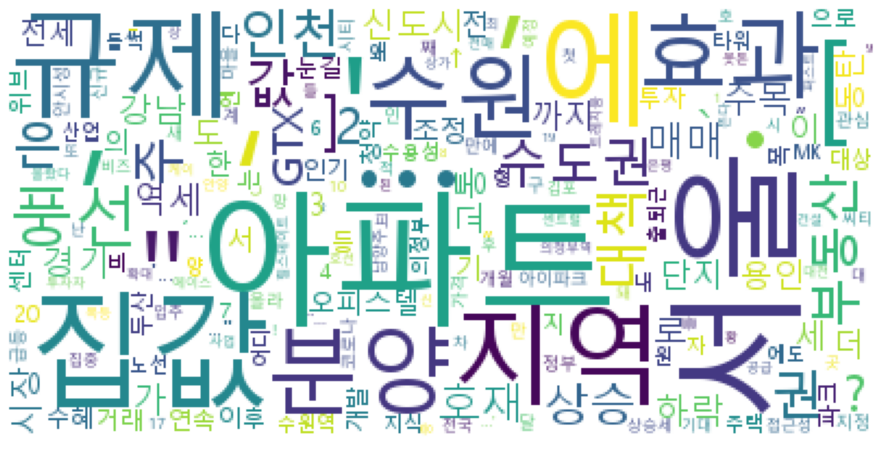

In [168]:
#워드 클라우드 만들기
data = ko.vocab().most_common(300)
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                     relative_scaling=0.2,
                     background_color='white').generate_from_frequencies(dict(data))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# 긍정/부정 라벨링

In [169]:
# positive사전 negative사전 만들기

from konlpy.tag import Okt
from collections import Counter

positive_words_path = './positive_words.txt'
positive2_words_path = './positive_words_2.txt'
negative_words_path = './negative_words.txt'
negative2_words_path = './negative_words_2.txt'
posneg2_path = './posneg2.txt'

with open(positive_words_path, encoding="utf8") as f:
    pos_words = f.readlines()
with open(positive2_words_path, encoding='utf8') as f:
    pos_words_2 = f.readlines()
with open(negative_words_path, encoding='utf8') as f:
    neg_words = f.readlines()
with open(negative2_words_path, encoding='utf8') as f:
    neg_words_2 = f.readlines()
with open(posneg2_path, encoding='utf8') as f:
    posneg_words = f.readlines()

pos_words= [x.strip() for x in pos_words]
pos_words_2= [x.strip() for x in pos_words_2]
neg_words = [y.strip() for y in neg_words]
neg_words_2 = [y.strip() for y in neg_words_2]
posneg_words = [z.strip() for z in posneg_words]

# news_poswords = [''"']
# for stopword in news_stopwords:
#     stopwords.append(stopword)
 
#len(pos_words)
#len(pos_words_2)
#len(posneg_words)

In [170]:
naver_news_1 = naver_news.drop(['title','content','ko_text_title'],axis=1)
naver_news_1.sort_values(by=['date'], inplace=True, ascending=True)

In [171]:
naver_news_1

,date,nouns
6,2017.07.05,"[전세, 서울, 출퇴근, 경기, 아파트, 눈길]"
7,2017.07.05,"[전세, 탈출, 서울, 출퇴근, 경기, 아파트, 인기]"
3,2017.07.06,"[부동산, 규제, 광명시]"
9,2017.07.06,"[전세, 피하, 서울, 출퇴근, 경기, 아파트]"
5,2017.07.07,"[서울, 출퇴근, 힐스테이트, 평택, 수요, 관심, 집중]"
...,...,...
413,2020.08.12,"[본격, 경기, 광주, 역세, 개발, 사업, 관심, 집중]"
414,2020.08.12,"[의정부, 부동산, 규제, 신고, 행진, 신규, 아파트, 분양, 열기, 후끈]"
411,2020.08.13,"[천장, 세종, 집값, 급등]"
405,2020.08.13,"[수도권, 아파트, 매매, 전세, 주춤, 관망, 지속]"


In [172]:
naver_news_ex = naver_news_1.reset_index(drop=True)
naver_news_test = naver_news_ex

In [173]:
naver_news_test['nouns'][0][0]

'전세'

In [175]:
for i in range(375):
    for j in range(len(naver_news_test['nouns'][i])):
        if naver_news_test['nouns'][i][j] in pos_words:
            naver_news_test['nouns'][i][j] = 1
        elif naver_news_test['nouns'][i][j] in pos_words_2:
            naver_news_test['nouns'][i][j] = 2
        elif naver_news_test['nouns'][i][j] in neg_words:
            naver_news_test['nouns'][i][j] = -1
        elif naver_news_test['nouns'][i][j] in neg_words_2:
            naver_news_test['nouns'][i][j] = -2
        elif naver_news_test['nouns'][i][j] not in posneg_words:
            naver_news_test['nouns'][i][j] = 0

In [176]:
naver_news_test

,date,nouns
0,2017.07.05,"[0, 0, 0, 0, 0, 0]"
1,2017.07.05,"[0, 1, 0, 0, 0, 0, 2]"
2,2017.07.06,"[0, -1, 0]"
3,2017.07.06,"[0, 0, 0, 0, 0, 0]"
4,2017.07.07,"[0, 0, 0, 0, 0, 1, 0]"
...,...,...
370,2020.08.12,"[0, 0, 0, 0, 1, 0, 1, 0]"
371,2020.08.12,"[0, 0, -1, 0, 0, 0, 0, 0, 1, 1]"
372,2020.08.13,"[0, 0, 0, 2]"
373,2020.08.13,"[0, 0, 0, 0, -1, 0, 1]"


In [177]:
# 긍정기사 갯수 세기
pos_count = 0
for i in range(len(naver_news_test['nouns'])):
    if ((1 in naver_news_test['nouns'][i]) or (2 in naver_news_test['nouns'][i])):
        if -1 not in naver_news_test['nouns'][i]:
            if -2 not in naver_news_test['nouns'][i]:
                pos_count += 1
pos_count

158

In [178]:
#부정기사 갯수 세기
neg_count = 0
for i in range(len(naver_news_test['nouns'])):
    if ((-1 in naver_news_test['nouns'][i]) or (-2 in naver_news_test['nouns'][i])):
        if 1 not in naver_news_test['nouns'][i]:
            if 2 not in naver_news_test['nouns'][i]:
                neg_count += 1
neg_count

69

In [179]:
# 긍정+부정 기사 갯수 세기
posneg_count = 0
for i in range(len(naver_news_test['nouns'])):
    if ((1 in naver_news_test['nouns'][i]) or (2 in naver_news_test['nouns'][i])):
        if (-1 in naver_news_test['nouns'][i]) or (-2 in naver_news_test['nouns'][i]):
            posneg_count += 1
posneg_count

54

In [180]:
# 무반응 기사 세기
inactive_count = 0
for i in range(len(naver_news_test['nouns'])):
    if -1 not in naver_news_test['nouns'][i]:
        if -2 not in naver_news_test['nouns'][i]:
            if 1 not in naver_news_test['nouns'][i]:
                if 2 not in naver_news_test['nouns'][i]:
                    inactive_count += 1
inactive_count

94

for i in range(len(naver_news_test['date'])):
    naver_news_test['date'][i] = naver_news_test['date'][i].split('.')
    

In [181]:
#datetime으로 변환
naver_news_test['datetime'] = pd.to_datetime(naver_news_test['date'])

In [182]:
naver_news_test

,date,nouns,datetime
0,2017.07.05,"[0, 0, 0, 0, 0, 0]",2017-07-05
1,2017.07.05,"[0, 1, 0, 0, 0, 0, 2]",2017-07-05
2,2017.07.06,"[0, -1, 0]",2017-07-06
3,2017.07.06,"[0, 0, 0, 0, 0, 0]",2017-07-06
4,2017.07.07,"[0, 0, 0, 0, 0, 1, 0]",2017-07-07
...,...,...,...
370,2020.08.12,"[0, 0, 0, 0, 1, 0, 1, 0]",2020-08-12
371,2020.08.12,"[0, 0, -1, 0, 0, 0, 0, 0, 1, 1]",2020-08-12
372,2020.08.13,"[0, 0, 0, 2]",2020-08-13
373,2020.08.13,"[0, 0, 0, 0, -1, 0, 1]",2020-08-13


In [183]:
naver_news_test['yearmonth'] = naver_news_test['datetime'].dt.strftime('%Y%m')

In [184]:
naver_news_test.head(20)

,date,nouns,datetime,yearmonth
0,2017.07.05,"[0, 0, 0, 0, 0, 0]",2017-07-05,201707
1,2017.07.05,"[0, 1, 0, 0, 0, 0, 2]",2017-07-05,201707
2,2017.07.06,"[0, -1, 0]",2017-07-06,201707
3,2017.07.06,"[0, 0, 0, 0, 0, 0]",2017-07-06,201707
4,2017.07.07,"[0, 0, 0, 0, 0, 1, 0]",2017-07-07,201707
5,2017.07.07,"[0, 0, 0, 0, 0, 0, 0, 0, 1]",2017-07-07,201707
6,2017.07.11,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]",2017-07-11,201707
7,2017.07.12,"[1, 2, 0, 0, 0]",2017-07-12,201707
8,2017.07.17,"[0, 0, 0, 0, 2]",2017-07-17,201707
9,2017.07.21,"[0, 0, 2]",2017-07-21,201707


In [185]:
noun = naver_news_test['nouns']

In [186]:
nono = noun.to_frame()

In [187]:
nono

,nouns
0,"[0, 0, 0, 0, 0, 0]"
1,"[0, 1, 0, 0, 0, 0, 2]"
2,"[0, -1, 0]"
3,"[0, 0, 0, 0, 0, 0]"
4,"[0, 0, 0, 0, 0, 1, 0]"
...,...
370,"[0, 0, 0, 0, 1, 0, 1, 0]"
371,"[0, 0, -1, 0, 0, 0, 0, 0, 1, 1]"
372,"[0, 0, 0, 2]"
373,"[0, 0, 0, 0, -1, 0, 1]"


In [188]:
b = nono.sum(axis=1)

In [189]:
b

0                   [0, 0, 0, 0, 0, 0]
1                [0, 1, 0, 0, 0, 0, 2]
2                           [0, -1, 0]
3                   [0, 0, 0, 0, 0, 0]
4                [0, 0, 0, 0, 0, 1, 0]
                    ...               
370           [0, 0, 0, 0, 1, 0, 1, 0]
371    [0, 0, -1, 0, 0, 0, 0, 0, 1, 1]
372                       [0, 0, 0, 2]
373             [0, 0, 0, 0, -1, 0, 1]
374           [0, 0, 0, 0, 1, 0, 0, 2]
Length: 375, dtype: object

In [190]:
# # for i in range(len(naver_news_test['nouns'])):
# #     for j in range(len(naver_news_test['nouns'][i])):
# day_total = []
# for i in range(len(naver_news_test['nouns'])):
#         total += sum(naver_news_test['nouns'][i])
#         day_total.append(total)

In [191]:
group = naver_news_test['nouns'].groupby([naver_news_test['yearmonth']]).sum()

In [192]:
type(group)

pandas.core.series.Series

In [193]:
month_grouping = pd.DataFrame(data=group)

In [194]:
month_grouping

,nouns
yearmonth,
201707,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, -1,..."
201709,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
201710,"[-1, 0, 0, 0, 0, 0, 1]"
201711,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1,..."
201712,"[0, 0, 0, 0, -1, 0, 0, 1]"
201801,"[0, 0, 0, 1, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0]"
201802,"[0, 0, 1]"
201803,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
201805,"[0, 0, 0, 0, -2, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,..."


In [195]:
month = month_grouping.reset_index(level='yearmonth')

In [196]:
sum(month['nouns'][0])

13

In [197]:
total = 0
for i in range(len(month['nouns'])):
    total = sum(month['nouns'][i])
    print(total)

13
-1
0
3
0
7
1
9
12
1
1
-1
8
2
-5
-13
2
5
7
7
1
3
6
15
2
4
4
6
18
10
0
0
38
3
21


In [221]:
##############################################################

In [199]:
type(month['nouns'][0])

list

In [203]:
# 한글 오류 수정 후 엑셀에서 다시불러오기
# input = open('./month2.csv')
# month = pd.monthFrame(pd.read_csv(input,sep=','))
li_score = []
a = 0
for i in range(len(month['nouns'])):
#     sample=month['nouns'][i].strip('][')
#     a = sample.split(',')
#     a = list(map(int, a))
    a = sum(month['nouns'][i])
    li_score.append(a)

    
li_yearmonth = []
for i in range(len(month['yearmonth'])):
    b = int(month['yearmonth'][i])
    li_yearmonth.append(b)
    
# li_yearmonth.insert(1, 201708)
# li_score.insert(1, 6)
# li_yearmonth.insert(9, 201804)
# li_score.insert(9, 11)
# li_yearmonth.insert(15, 201810)
# li_score.insert(15, 6)


In [204]:
li_score

[13,
 -1,
 0,
 3,
 0,
 7,
 1,
 9,
 12,
 1,
 1,
 -1,
 8,
 2,
 -5,
 -13,
 2,
 5,
 7,
 7,
 1,
 3,
 6,
 15,
 2,
 4,
 4,
 6,
 18,
 10,
 0,
 0,
 38,
 3,
 21]

In [205]:
df1 = pd.DataFrame(li_score)
df2 = pd.DataFrame(li_yearmonth)
result = pd.concat([df2, df1], axis =1)
result.columns = ['ym', 'score']

In [206]:
result

,ym,score
0,201707,13
1,201709,-1
2,201710,0
3,201711,3
4,201712,0
5,201801,7
6,201802,1
7,201803,9
8,201805,12
9,201806,1


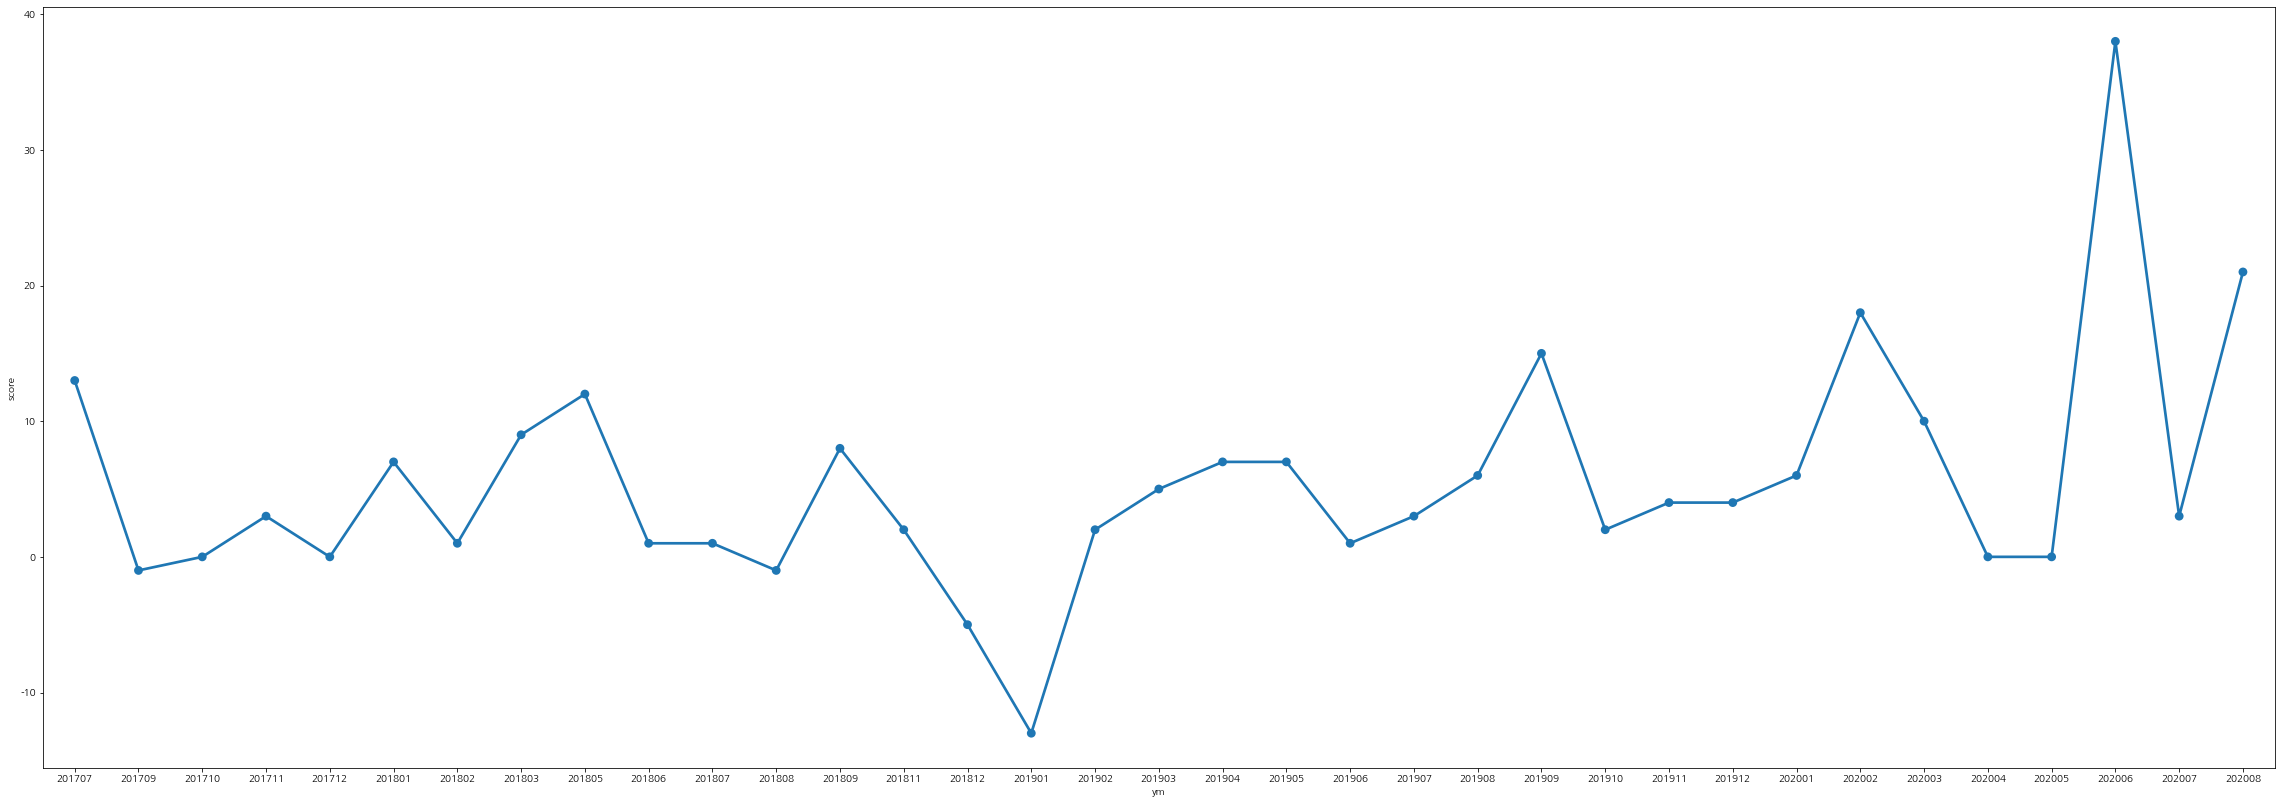

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(40,14))
sns.pointplot(data=result, x="ym", y="score", ax=ax)

Text(0.5, 1.0, '감성분석점수')

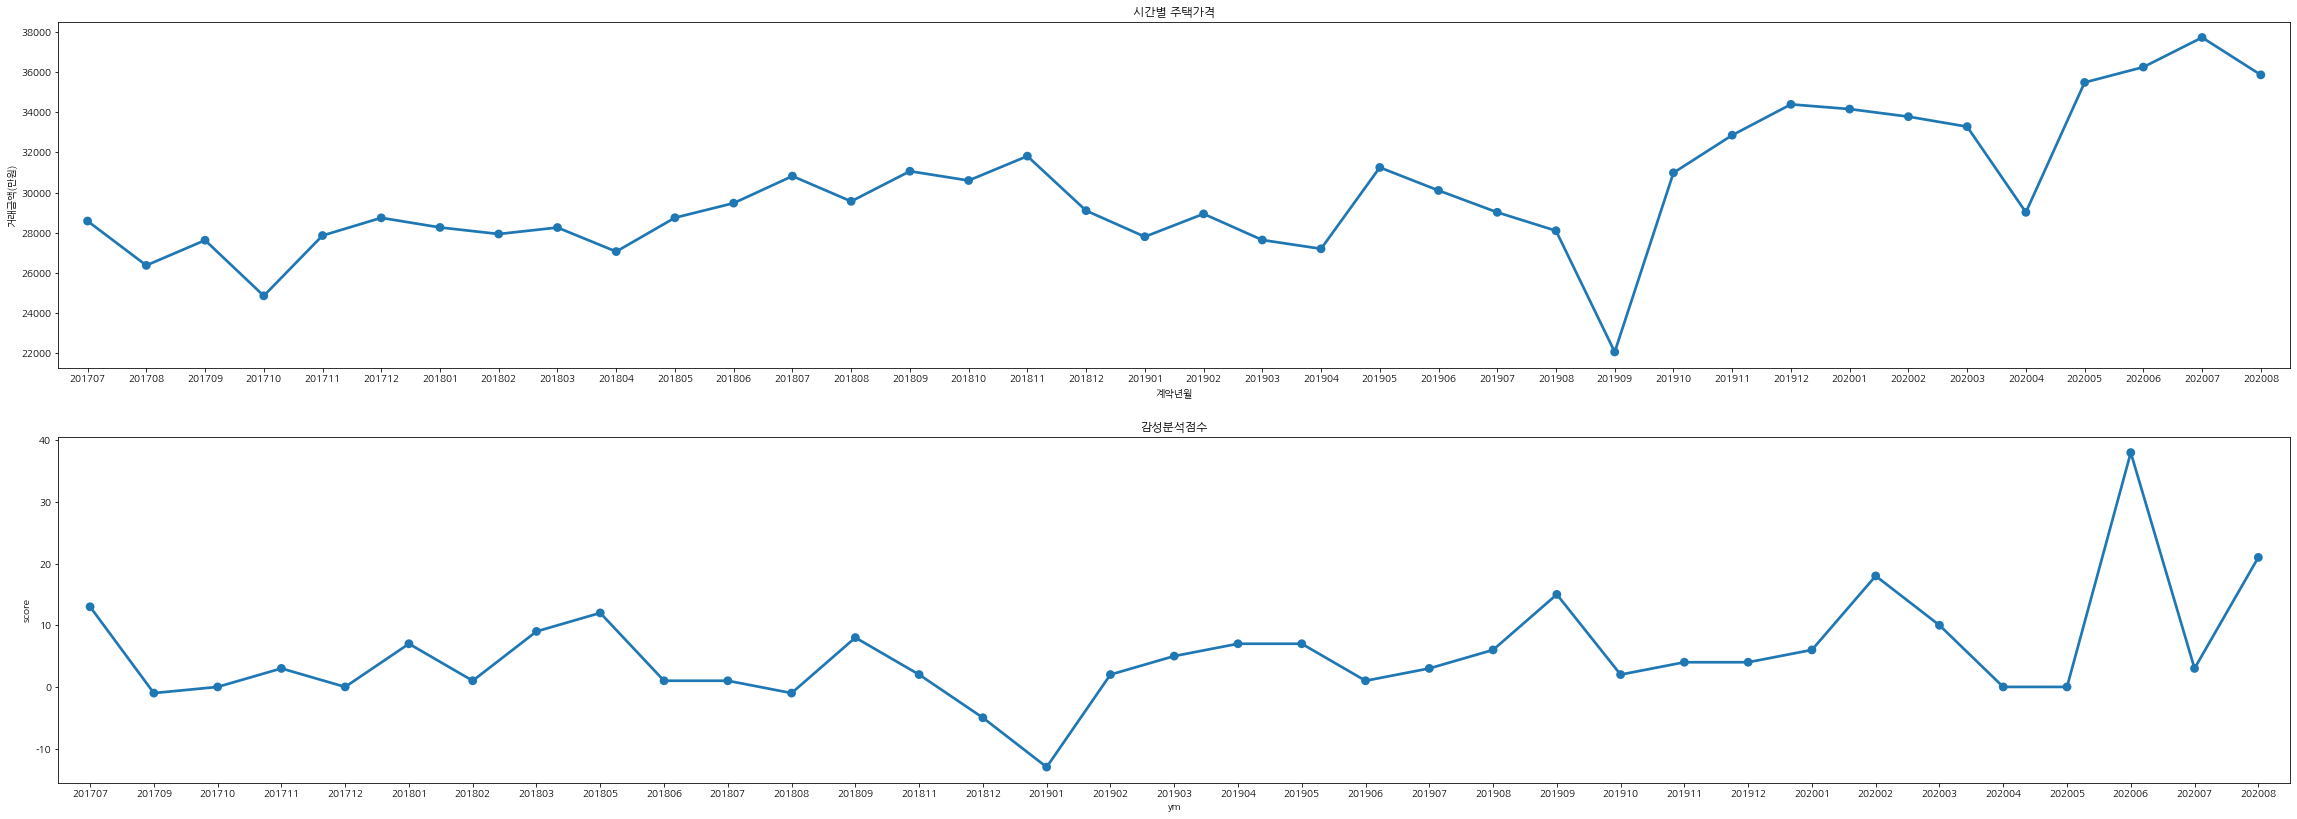

In [230]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(2,1,figsize=(40,14))
sns.pointplot(data=apt2, x="계약년월", y="거래금액(만원)", ax=ax[0])
ax[0].set_title('시간별 주택가격')
sns.pointplot(data=result, x="ym", y="score", ax=ax[1])
ax[1].set_title('감성분석점수')

# ######################수원시 주택가격 분석###################

In [208]:
import pandas as pd 
import numpy as np

input1 = open('C:/Users/손은주/Multicampus/part2/아파트(매매)_실거래가-1.csv')
input2 = open('C:/Users/손은주/Multicampus/part2/아파트(매매)_실거래가-2.csv')
input3 = open('C:/Users/손은주/Multicampus/part2/아파트(매매)_실거래가-3.csv')
input4 = open('C:/Users/손은주/Multicampus/part2/아파트(매매)_실거래가-4.csv')

apt_price1 = pd.DataFrame(pd.read_csv(input1, sep=','))
apt_price2 = pd.DataFrame(pd.read_csv(input2, sep=','))
apt_price3 = pd.DataFrame(pd.read_csv(input3, sep=','))
apt_price4 = pd.DataFrame(pd.read_csv(input4, sep=','))
apt_price1

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명
0,경기도 수원팔달구 고등동,67-19,67,19,동은,73.9300,201707,3,22000,3,2006,고매로 40
1,경기도 수원팔달구 고등동,67-19,67,19,동은,73.9300,201709,28,21800,7,2006,고매로 40
2,경기도 수원팔달구 고등동,67-19,67,19,동은,73.9300,201712,9,22000,4,2006,고매로 40
3,경기도 수원팔달구 고등동,67-19,67,19,동은,78.4900,201802,27,20000,10,2006,고매로 40
4,경기도 수원팔달구 고등동,305-7,305,7,아이제이빌,84.7907,201708,29,23500,9,2008,갓매산로76번길 6
...,...,...,...,...,...,...,...,...,...,...,...,...
2268,경기도 수원팔달구 화서동,769,769,0,화서한신휴플러스,84.9800,201803,14,33000,4,2014,수성로258번길 52
2269,경기도 수원팔달구 화서동,769,769,0,화서한신휴플러스,84.9800,201803,23,34700,15,2014,수성로258번길 52
2270,경기도 수원팔달구 화서동,769,769,0,화서한신휴플러스,69.5100,201804,29,30400,6,2014,수성로258번길 52
2271,경기도 수원팔달구 화서동,769,769,0,화서한신휴플러스,84.9800,201805,26,33000,4,2014,수성로258번길 52


In [209]:
apt_price2

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명
0,경기도 수원팔달구 고등동,67-19,67,19,동은,73.93,201811,16,20000,7,2006,고매로 40
1,경기도 수원팔달구 고등동,67-19,67,19,동은,73.93,201905,30,23500,5,2006,고매로 40
2,경기도 수원팔달구 고등동,Jan-94,94,1,해창,65.36,201807,7,20000,3,1979,갓매산로86번길 40
3,경기도 수원팔달구 고등동,Jan-94,94,1,해창,65.36,201807,26,18800,5,1979,갓매산로86번길 40
4,경기도 수원팔달구 고등동,Jan-94,94,1,해창,54.25,201808,1,17000,3,1979,갓매산로86번길 40
...,...,...,...,...,...,...,...,...,...,...,...,...
1857,경기도 수원팔달구 화서동,769,769,0,화서한신휴플러스,84.98,201811,5,35500,2,2014,수성로258번길 52
1858,경기도 수원팔달구 화서동,769,769,0,화서한신휴플러스,84.98,201811,15,36800,13,2014,수성로258번길 52
1859,경기도 수원팔달구 화서동,769,769,0,화서한신휴플러스,69.51,201812,29,34000,10,2014,수성로258번길 52
1860,경기도 수원팔달구 화서동,769,769,0,화서한신휴플러스,84.98,201906,8,36500,11,2014,수성로258번길 52


In [210]:
apt_price = pd.concat([apt_price1, apt_price2, apt_price3, apt_price4], join='outer')
apt_price.head(30)

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명
0,경기도 수원팔달구 고등동,67-19,67,19,동은,73.9300,201707,3,22000,3,2006,고매로 40
1,경기도 수원팔달구 고등동,67-19,67,19,동은,73.9300,201709,28,21800,7,2006,고매로 40
2,경기도 수원팔달구 고등동,67-19,67,19,동은,73.9300,201712,9,22000,4,2006,고매로 40
3,경기도 수원팔달구 고등동,67-19,67,19,동은,78.4900,201802,27,20000,10,2006,고매로 40
4,경기도 수원팔달구 고등동,305-7,305,7,아이제이빌,84.7907,201708,29,23500,9,2008,갓매산로76번길 6
5,경기도 수원팔달구 고등동,Jan-94,94,1,해창,54.2500,201707,6,15000,5,1979,갓매산로86번길 40
6,경기도 수원팔달구 고등동,Jan-94,94,1,해창,54.2500,201707,15,15800,5,1979,갓매산로86번길 40
7,경기도 수원팔달구 고등동,Jan-94,94,1,해창,76.2000,201707,17,21300,4,1979,갓매산로86번길 40
8,경기도 수원팔달구 고등동,Jan-94,94,1,해창,76.2000,201707,20,20500,1,1979,갓매산로86번길 36
9,경기도 수원팔달구 고등동,Jan-94,94,1,해창,65.3600,201707,28,18000,1,1979,갓매산로86번길 40


In [211]:
apt_price.shape

(6831, 12)

In [212]:
apt_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6831 entries, 0 to 198
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시군구       6831 non-null   object 
 1   번지        6831 non-null   object 
 2   본번        6831 non-null   int64  
 3   부번        6831 non-null   int64  
 4   단지명       6831 non-null   object 
 5   전용면적(㎡)   6831 non-null   float64
 6   계약년월      6831 non-null   int64  
 7   계약일       6831 non-null   int64  
 8   거래금액(만원)  6831 non-null   int64  
 9   층         6831 non-null   int64  
 10  건축년도      6831 non-null   int64  
 11  도로명       6831 non-null   object 
dtypes: float64(1), int64(7), object(4)
memory usage: 693.8+ KB


In [213]:
apt_price.describe()

,본번,부번,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도
count,6831.000000,6831.000000,6831.000000,6831.000000,6831.000000,6831.000000,6831.000000,6831.00000
mean,449.197921,2.551749,70.440225,201858.764749,15.596692,30203.670034,8.810130,1999.12575
std,301.028278,6.636289,27.821946,98.098559,8.672231,12564.835143,5.860216,9.87412
min,11.000000,0.000000,10.938000,201707.000000,1.000000,5000.000000,1.000000,1979.00000
25%,209.000000,0.000000,52.680000,201803.000000,8.000000,20800.000000,4.000000,1992.00000
50%,384.000000,0.000000,60.460000,201812.000000,15.000000,29200.000000,8.000000,1999.00000
75%,656.000000,2.000000,84.938000,201912.000000,23.000000,38000.000000,12.000000,2009.00000
max,1170.000000,75.000000,189.959000,202008.000000,31.000000,89980.000000,33.000000,2020.00000


In [214]:
apt = apt_price.sort_values(by = ['계약년월','계약일'])
apt.head(30)

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명
88,경기도 수원팔달구 매산로2가,90,90,0,대한대우,84.9900,201707,1,31000,4,1999,권선로 477
293,경기도 수원팔달구 우만동,517,517,0,신미주,61.3800,201707,1,15900,1,1989,월드컵로321번길 17
333,경기도 수원팔달구 우만동,28,28,0,우만주공1단지,47.2500,201707,1,22500,3,1988,중부대로223번길 102
616,경기도 수원팔달구 우만동,600,600,0,월드메르디앙,84.2370,201707,1,40000,28,2004,권광로 373
755,경기도 수원팔달구 우만동,496,496,0,풍림,39.6000,201707,1,14000,4,1987,세지로 439-14
871,경기도 수원팔달구 인계동,384,384,0,래미안노블클래스1단지,84.9900,201707,1,45800,17,2009,권광로 246
1059,경기도 수원팔달구 인계동,163,163,0,선경1,59.3350,201707,1,21800,5,1993,권광로317번길 12
1079,경기도 수원팔달구 인계동,159,159,0,선경3,84.7900,201707,1,28500,15,1996,권광로317번길 15
1343,경기도 수원팔달구 인계동,1168,1168,0,인계희성연인,84.9450,201707,1,30000,16,2012,중부대로 96-19
392,경기도 수원팔달구 우만동,28,28,0,우만주공2단지,58.0100,201707,2,25950,14,1989,중부대로223번길 92


In [215]:
apt['단지명'].unique()

array(['대한대우', '신미주', '우만주공1단지', '월드메르디앙', '풍림', '래미안노블클래스1단지', '선경1',
       '선경3', '인계희성연인', '우만주공2단지', '익주', '동은', '수원광교 양우 내안애 애플 아파트',
       '래미안노블클래스2단지', '수원인계푸르지오', '문화맨션', '블루오션', '화서5주공', '화서위브하늘채',
       '삼성', '신반포수원(한신)', '영광', '인계미루아파트', '인계파밀리에', '동오', '꽃뫼양지마을대우',
       '민영루이스', '해창', '인계극동스타클래스아파트', '화서4단지주공', '벽산', '우만주공4단지', '전원',
       '수원화서역 동문굿모닝힐', '현대', '건영캐스빌', '동수원신도브래뉴', '꽃뫼마을엘지', '화서한신휴플러스',
       '한화꿈에그린파크', '화서블루밍푸른숲', '꽃뫼마을풍림', '삼익세라믹', '꽃뫼마을신동아', '꽃뫼버들마을진흥',
       '화서3단지주공', '신성미소지움', '무궁화', '수정', '꽃뫼양지마을현대', '벽산그랜드코아', '금성',
       '선경', 'CJ아파트 101동', '성원쌍떼빌', '장안', '코스모골드', '꽃뫼마을코오롱', '동도센트리움',
       '풍림아이원', '계림아파트', '성원', 'KCC파크타운', '우리하이빌', '아이타워', '화서맨션가동',
       '화서맨션다동', '삼호', '포레스트', '한진현대', '유엘비치나움', '인계베스트빌', '아이제이빌',
       '인계지음', '삼호파크타워', '신우상가', '연향예스빌', '꽃뫼버들마을금강', '이건', '우주그린', '칠성',
       '진우', '선경2', '보은맨션', '(953-2)', '해피포트', '명진', '현대콤비타운', '은하',
       '대명쉐르빌', '무비하임', '엘디그린토피아', '다림(975-15)', '다림늘푸른아파트', 'ELYSIA',
       '리

In [216]:
apt['계약년월'] = apt['계약년월'].astype(str)
apt['건축년도'] = apt['건축년도'].astype(str)

apt["year"]=apt["계약년월"].str[0:4]
apt["month"] = apt["계약년월"].str[4:6]

In [217]:
apt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6831 entries, 88 to 81
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시군구       6831 non-null   object 
 1   번지        6831 non-null   object 
 2   본번        6831 non-null   int64  
 3   부번        6831 non-null   int64  
 4   단지명       6831 non-null   object 
 5   전용면적(㎡)   6831 non-null   float64
 6   계약년월      6831 non-null   object 
 7   계약일       6831 non-null   int64  
 8   거래금액(만원)  6831 non-null   int64  
 9   층         6831 non-null   int64  
 10  건축년도      6831 non-null   object 
 11  도로명       6831 non-null   object 
 12  year      6831 non-null   object 
 13  month     6831 non-null   object 
dtypes: float64(1), int64(5), object(8)
memory usage: 800.5+ KB


In [218]:
apt['year'] = apt['year'].astype(int)
apt['건축년도'] = apt['건축년도'].astype(int)

apt['age'] = apt['year'] - apt['건축년도'] 

In [219]:
apt

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,year,month,age
88,경기도 수원팔달구 매산로2가,90,90,0,대한대우,84.990,201707,1,31000,4,1999,권선로 477,2017,07,18
293,경기도 수원팔달구 우만동,517,517,0,신미주,61.380,201707,1,15900,1,1989,월드컵로321번길 17,2017,07,28
333,경기도 수원팔달구 우만동,28,28,0,우만주공1단지,47.250,201707,1,22500,3,1988,중부대로223번길 102,2017,07,29
616,경기도 수원팔달구 우만동,600,600,0,월드메르디앙,84.237,201707,1,40000,28,2004,권광로 373,2017,07,13
755,경기도 수원팔달구 우만동,496,496,0,풍림,39.600,201707,1,14000,4,1987,세지로 439-14,2017,07,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,경기도 수원팔달구 인계동,163,163,0,선경1,59.335,202008,18,25300,15,1993,권광로317번길 12,2020,08,27
33,경기도 수원팔달구 우만동,28,28,0,우만주공2단지,58.010,202008,21,27000,1,1989,중부대로223번길 92,2020,08,31
79,경기도 수원팔달구 인계동,371-1,371,1,삼성,84.880,202008,21,35900,10,1996,권광로276번길 9,2020,08,24
80,경기도 수원팔달구 인계동,371-1,371,1,삼성,59.880,202008,22,28500,16,1996,권광로276번길 9,2020,08,24


In [220]:
apt.head()

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,year,month,age
88,경기도 수원팔달구 매산로2가,90,90,0,대한대우,84.990,201707,1,31000,4,1999,권선로 477,2017,07,18
293,경기도 수원팔달구 우만동,517,517,0,신미주,61.380,201707,1,15900,1,1989,월드컵로321번길 17,2017,07,28
333,경기도 수원팔달구 우만동,28,28,0,우만주공1단지,47.250,201707,1,22500,3,1988,중부대로223번길 102,2017,07,29
616,경기도 수원팔달구 우만동,600,600,0,월드메르디앙,84.237,201707,1,40000,28,2004,권광로 373,2017,07,13
755,경기도 수원팔달구 우만동,496,496,0,풍림,39.600,201707,1,14000,4,1987,세지로 439-14,2017,07,30


In [221]:
apt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6831 entries, 88 to 81
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시군구       6831 non-null   object 
 1   번지        6831 non-null   object 
 2   본번        6831 non-null   int64  
 3   부번        6831 non-null   int64  
 4   단지명       6831 non-null   object 
 5   전용면적(㎡)   6831 non-null   float64
 6   계약년월      6831 non-null   object 
 7   계약일       6831 non-null   int64  
 8   거래금액(만원)  6831 non-null   int64  
 9   층         6831 non-null   int64  
 10  건축년도      6831 non-null   int32  
 11  도로명       6831 non-null   object 
 12  year      6831 non-null   int32  
 13  month     6831 non-null   object 
 14  age       6831 non-null   int32  
dtypes: float64(1), int32(3), int64(5), object(6)
memory usage: 773.8+ KB


In [222]:
apt1 = apt.reset_index(drop=True)

In [223]:
apt1

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,year,month,age
0,경기도 수원팔달구 매산로2가,90,90,0,대한대우,84.990,201707,1,31000,4,1999,권선로 477,2017,07,18
1,경기도 수원팔달구 우만동,517,517,0,신미주,61.380,201707,1,15900,1,1989,월드컵로321번길 17,2017,07,28
2,경기도 수원팔달구 우만동,28,28,0,우만주공1단지,47.250,201707,1,22500,3,1988,중부대로223번길 102,2017,07,29
3,경기도 수원팔달구 우만동,600,600,0,월드메르디앙,84.237,201707,1,40000,28,2004,권광로 373,2017,07,13
4,경기도 수원팔달구 우만동,496,496,0,풍림,39.600,201707,1,14000,4,1987,세지로 439-14,2017,07,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6826,경기도 수원팔달구 인계동,163,163,0,선경1,59.335,202008,18,25300,15,1993,권광로317번길 12,2020,08,27
6827,경기도 수원팔달구 우만동,28,28,0,우만주공2단지,58.010,202008,21,27000,1,1989,중부대로223번길 92,2020,08,31
6828,경기도 수원팔달구 인계동,371-1,371,1,삼성,84.880,202008,21,35900,10,1996,권광로276번길 9,2020,08,24
6829,경기도 수원팔달구 인계동,371-1,371,1,삼성,59.880,202008,22,28500,16,1996,권광로276번길 9,2020,08,24


## 상관관계 분석

In [224]:
apt1['거래금액(만원)'].corr(apt1['층'])

0.29020131267099913

In [225]:
apt1['거래금액(만원)'].corr(apt1['전용면적(㎡)'])

0.7295497023452978

In [226]:
apt1['거래금액(만원)'].corr(apt1['age'])

-0.2929056262886663

In [227]:
apt2 = apt1[['계약년월','거래금액(만원)']].groupby(['계약년월'], as_index=False).mean()

## 감정분석과 주택가격/ 주택가격

In [122]:
#참고

# https://blog.naver.com/jeonghj66/222057942747

# https://blog.naver.com/ahn128/221936967545

# 형태소 분석 https://blog.naver.com/dalgoon02121/222051184805

In [ ]:
#한솔씨가 한것
#https://colab.research.google.com/drive/1kS2kzcsgPh8d8dwmBHF0_CbB22KN1yqB?usp=sharing#scrollTo=s_xUC7ETyBbr